In [374]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch

### Fitting a fixed sqrt curve to saccade data from the paper to get a function for amplitude generation

In [376]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

### GENERATING EQUATION FOR MAIN SEQUENCE

In [378]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func_exp(x, a = a_exp, b = b_exp, c = c_exp):
  return a * (1 - np.exp(-(x-b)/c))
def func_sigmoid(x,a,b,c):
  return a/(1+(b/x)**c)
def func_fixsqrt(x,a = a_fs,b = b_fs,c = c_fs):
  return a + b*(x-c)**0.5


### Fitting a fixed sqrt curve to saccade data from the paper to get a function for amplitude generation

In [380]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

### Skip the curve fitting algorithm, the fitted equations are above

In [382]:
ydata = np.random.uniform([340],[440],15)
ydata = np.append(ydata,np.random.uniform([440],[550],15))
ydata = np.append(ydata,np.random.uniform([500],[670],15))
ydata = np.append(ydata, np.random.uniform([570],[700],15))
len(ydata)


60

In [383]:
xdata = np.concatenate(([5]*15, [10]*15, [15]*15,[20]*15))
xdata

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20])

In [384]:
from scipy.optimize import curve_fit
def func_exp(x, a, b, c):
  return a * (1 - np.exp(-(x-b)/c))
def func_sigmoid(x,a,b,c):
  return a/(1+(b/x)**c)
def func_fixsqrt(x,a,b,c):
  return a + b*(x-c)**0.5

In [385]:
popt_fs, pcov_fs = curve_fit(func_fixsqrt, xdata, ydata) #just based on ranges of velocity
popt_sig, pcov_sig = curve_fit(func_sigmoid, xdata, ydata)
popt_fs2, pcov_fs2 = curve_fit(func_fixsqrt, xy_2.amp, xy_2.vel)  #using the data from the plot
# popt_exp, pcov_exp = curve_fit(func_exp, xdata, ydata)

/var/folders/gs/947mbm613t7_7whyg959snch0000gn/T/ipykernel_13959/3726250257.py:7: RuntimeWarning: invalid value encountered in sqrt
  return a + b*(x-c)**0.5
/var/folders/gs/947mbm613t7_7whyg959snch0000gn/T/ipykernel_13959/3726250257.py:5: RuntimeWarning: invalid value encountered in power
  return a/(1+(b/x)**c)


NameError: name 'xy_2' is not defined

In [ ]:
plt.scatter(xy.amp,xy.vel)
plt.plot(xdata, func_fixsqrt(xdata, *popt_fs))
# plt.plot(xdata, func_fixsqrt(xdata, *popt_fs2))
ran_x2 = np.linspace(0.5,6,10) #amp < 6
plt.plot(ran_x2, func_exp(ran_x2, *popt_exp))
plt.scatter(xdata, ydata, c='#2073BC')
# plt.label('fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_fs))
# plt.title("comparing fits")
# plt.legend(["fix sqrt","original" ])

In [ ]:
print('Fix_sqrt: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_fs))

ASSUMPTIONS


1. Only 2 saccades - main and corrective
2. Upper limit for hypermetria first saccade accuracy?
3. %allowable error in the velocity ranges?
4. Will the corrected saccade ever reach the target?

#### For amplitude < 6 degree

In [ ]:
# # Define the directory to the file
# dir = '/content/xy_data_amp_less_than_6.txt'

# # Open and read the file
# with open(dir, 'r') as f:
#     # Split each line, then convert each element to an integer
#     matrix = [[float(value) for value in line.split()] for line in f]

# columns = list(zip(*matrix))
# xdata = columns[0]
# ydata = columns[1]

In [ ]:
popt_exp, pcov_exp = curve_fit(func_exp, xdata, ydata)

In [ ]:
x = [np.arange(0,6,1)]
plt.plot(x, func_exp(x, *popt_exp))
plt.plot(xdata, ydata, 'bo')
# plt.label('fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_fs))
plt.title("comparing fits")
plt.legend(["exp","original" ])
plt.show()

In [ ]:
print('Fix_exp: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_exp))

### Laser

In [407]:
left = [-15, -7.5, -10, -2.5]
right = [15, 7.5, 10, 2.5]
stim_time = [0,1.259, 2.513, 3.761, 5.009, 6.263, 7.511, 8.759, 9.999,10.5]

In [409]:
#num = 1 or 2 to decide if the test starts from left side or right side
def gen_target(left,right,num):
  l2 = left
  r2 = right
  random.shuffle(l2)
  random.shuffle(r2)
  stimulus = [0]
    # stimulus starts on the left side
  if num == 1:
    for i in range(len(l2)):
      stimulus.append(l2[i])
      stimulus.append(r2[i])
    stimulus.append(r2[i])
      # stimulus starts on the right side
  else:
    for i in range(len(r2)):
      stimulus.append(r2[i])
      stimulus.append(l2[i])
    stimulus.append(l2[i])
  return stimulus

### Stimulus starting on left (1)

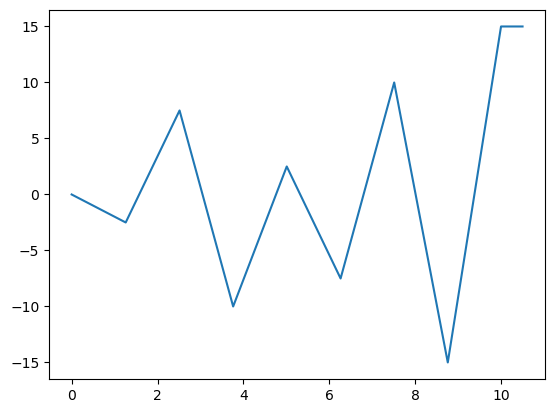

In [412]:
stimulus = gen_target(left,right,1)
plt.plot(stim_time, stimulus)

### Stimulus starting on right (not equal to 1)

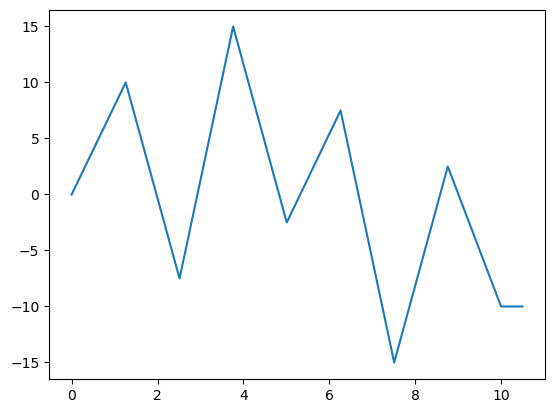

In [415]:
stimulus = gen_target(left,right,0)
plt.plot(stim_time, stimulus)

In [417]:
reconstructed_time=[0,1.259,1.260,2.513,2.514,3.761,3.762,5.009,5.010,6.263,6.264,7.511,7.512,8.759, 8.760, 9.999,10.000,10.5]
def gen_reconstructed_laser(stimulus):
  stim = stimulus[:-1]
  reconstructed_laser = [val for val in stim for _ in (0, 1)]
  return reconstructed_laser

In [419]:
reconst_laser = gen_reconstructed_laser(stimulus)
reconstruction = pd.DataFrame([reconstructed_time,reconst_laser]).T
reconstruction.columns = ["Time","Amplitude"]
reconstruction.head()

,Time,Amplitude
0,0.000,0.0
1,1.259,0.0
2,1.260,10.0
3,2.513,10.0
4,2.514,-7.5


### Target Sequence

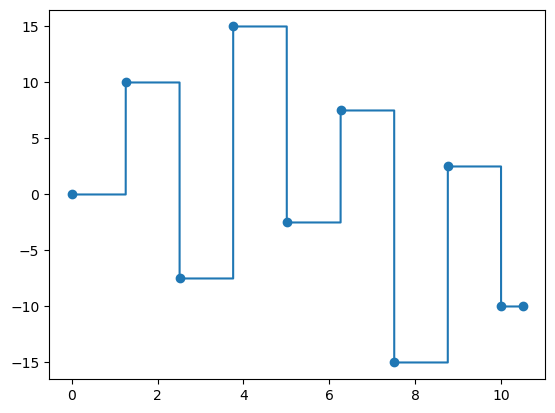

In [422]:
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.scatter(stim_time, stimulus)

## Generating the saccades

### Functions to produce latency, velocity and amplitude

In [426]:
#using this set of values for velocity ranges for specific angles

##UPDATE: CANNOT USE A FIXED AMPLITUDE BECAUSE THE AMP VARIES WITH THE ACCURACY
# def gen_velocity(amplitude):
#   amplitude = np.abs(amplitude)
#   if amplitude ==5:
#     return (np.random.uniform(260,440))
#   elif amplitude == 10:
#     return (np.random.uniform(400,600))
#   elif amplitude == 15:
#     return (np.random.uniform(500,670))
#   elif amplitude == 17.5:
#     return (np.random.uniform(4500,630))
#   elif amplitude == 20:
#     return (np.random.uniform(570,760))
#   elif amplitude == 22.5:
#     return (np.random.uniform(610,770))
#   elif amplitude == 25:
#     return (np.random.uniform(650,810))
#   elif amplitude == 30:
#     return (np.random.uniform(700,850))

#generate the velocity for the ALL saccade
def gen_velocity(amplitude):
  # print("input amp", amplitude)
  amplitude = np.abs(amplitude)
  if amplitude <= 6:
  # vel = func_exp(amplitude, *popt_exp)
      vel = func_exp(amplitude,a_exp,b_exp,c_exp)
  else:
      vel = func_fixsqrt(amplitude,a_fs,b_fs,c_fs) + np.random.uniform(0,15)*(-1)**np.random.randint(2)
  # print(vel)
  return vel

#generate the latency for a saccade for each subject
def gen_latency(subject):
    # normal subject latency parameters
    if subject == "N":
      return np.random.uniform(0.1,0.200)
    # abnormal subject latency range
    else:
      return np.random.uniform(0.1,0.2) #for a first pass we are only modeling changes in accuracy

#generate the latency for the correcting saccade
def gen_latency_correcting(subject, prev_lat):
    if subject == "N":
      return np.random.uniform(0.050,0.15)
    else:
      return np.random.uniform(0.050,0.15) #for a first pass we are only modeling changes in accuracy

#generate accuracy for the saccade
def gen_accuracy(subject, condition, sac_seq):
# normal subject accuracy range
  if subject == "N":
    if sac_seq == "P":
      # return np.random.uniform(0.70,1.20)
      return 1
    else: #correcting saccade
      return 1
# abnormal subject accuracy range
  else: #abnormal saccade
    if condition == "hyper":
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(1.1,1.5) #what's the upper limit?
      else: #corrective saccade
        return np.random.uniform(1.00,1.1)
    else: #hypometria
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(0.20,0.70)
      else: #corrective saccade
        return np.random.uniform(0.90,1)

### Normal Waveform

In [429]:
def gen_waveform(stimulus, subject, condition, num):
  wave = [0, 0]
  time = [0, 1.259]
  main_seq = []
  for idx in range(len(stimulus)-1):  # Avoids out-of-range issues with stimulus[idx+1]
      # First time point: Start of the saccade (stim start + latency)
      lat = gen_latency(subject)
      time.append(time[-1] + lat)  # Appends new latency time
      wave.append(wave[-1])   # Appends current stimulus level

      # print("Step 1:", time[-4:], wave[-4:])

      # Second point: First saccade amplitude
      # amplitude change
      amp = gen_accuracy(subject, condition, "P") * stimulus[idx + 1] - wave[-1]
      wave.append(amp + wave[-1])  # Amplitude added to last wave point
      # generate velocity
      vel = gen_velocity(amp)
      time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
      main_seq.append([vel,amp])
      # print("Step 2:", amp, vel, time[-4:], wave[-4:])

      # Hold the saccade
      lat2 = gen_latency_correcting(subject, lat)
      time.append(time[-1] + lat2)  # Time after latency correction
      wave.append(wave[-1])  # Holds at current amplitude
      # print("Step 3:", lat2, time[-4:], wave[-4:])

      # Third point: Corrective saccade
      amp_c = gen_accuracy(subject, condition, "C") * stimulus[idx + 1] - amp
      vel_c = gen_velocity(amp_c)
      time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
      wave.append(amp_c + amp)  # New amplitude after corrective saccade
      main_seq.append([vel_c,amp_c])
      # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

      # Hold the corrective saccade
      if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
          break
      final_amp = wave[-1]  # Hold at current amplitude for final correction
      time.append(stim_time[idx + 2])  # Appends the next stimulation time
      wave.append(final_amp)  # Append final amplitude
  time.append(10.5)
  wave.append(wave[-1])
      # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])
  return time, wave, main_seq

Text(0.5, 1.0, 'Normal Saccade')

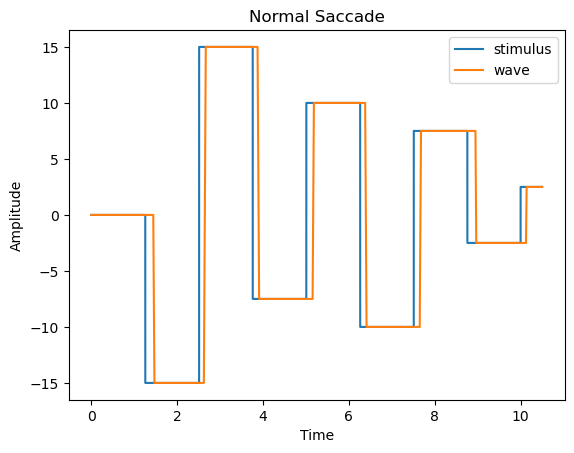

In [431]:
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"N","none",0)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.plot(time, wave)
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Normal Saccade")

In [433]:
reconst_laser = gen_reconstructed_laser(stimulus)
reconstruction = pd.DataFrame([reconstructed_time,reconst_laser]).T
reconstruction.columns = ["Time","Amplitude"]
reconstruction.head()

,Time,Amplitude
0,0.000,0.0
1,1.259,0.0
2,1.260,-15.0
3,2.513,-15.0
4,2.514,15.0


In [435]:
patient = pd.DataFrame([time,wave]).T
patient.columns = ["Time","Amplitude"]
patient.head()

,Time,Amplitude
0,0.000000,0.0
1,1.259000,0.0
2,1.445395,0.0
3,1.472122,-15.0
4,1.565671,-15.0


In [437]:
combined_data = pd.merge(reconstruction,patient,how = 'outer',on = 'Time')
combined_data.columns = ['Time','Stimulus','Patient']
combined_data.interpolate(method='linear').head()

,Time,Stimulus,Patient
0,0.000000,0.0,0.0
1,1.259000,0.0,0.0
2,1.260000,-15.0,0.0
3,1.445395,-15.0,0.0
4,1.472122,-15.0,-15.0


### Abnormal Saccade

In [440]:
#trial code
wave = [0, 0]
time = [0, 1.259]

for idx in range(len(stimulus)-1):  # Avoids out-of-range issues with stimulus[idx+1]
    # First time point: Start of the saccade (stim start + latency)
    lat = gen_latency("A")
    time.append(time[-1] + lat)  # Appends new latency time
    wave.append(wave[-1])   # Appends current stimulus level
    # print("Step 1:", time[-4:], wave[-4:])

    # Second point: First saccade amplitude
    amp = gen_accuracy("A", "hyper", "P") * stimulus[idx + 1] - wave[-1]
    wave.append(amp + wave[-1])  # Amplitude added to last wave point
    vel = gen_velocity(amp)
    time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
    # print("Step 2:", amp, vel, time[-4:], wave[-4:])

    # Hold the saccade
    lat2 = gen_latency_correcting("N", lat)
    time.append(time[-1] + lat2)  # Time after latency correction
    wave.append(wave[-1])  # Holds at current amplitude
    # print("Step 3:", lat2, time[-4:], wave[-4:])

    # Third point: Corrective saccade
    amp_c = gen_accuracy("A", "hyper", "C") * stimulus[idx + 1] - amp
    vel_c = gen_velocity(amp_c)
    time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
    wave.append(amp_c + amp)  # New amplitude after corrective saccade
    # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

    # Hold the corrective saccade
    if idx >= len(stimulus) - 2:  # Ensure we don’t exceed `stimulus` length
      break
    final_amp = wave[-1]  # Hold at current amplitude for final correction
    time.append(stim_time[idx + 2])  # Appends the next stimulation time
    wave.append(final_amp)  # Append final amplitude
    # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])


Checking if the 'gen_waveform' function works well for abnormal saccades

Text(0.5, 1.0, 'Biateral Hypometric Saccades')

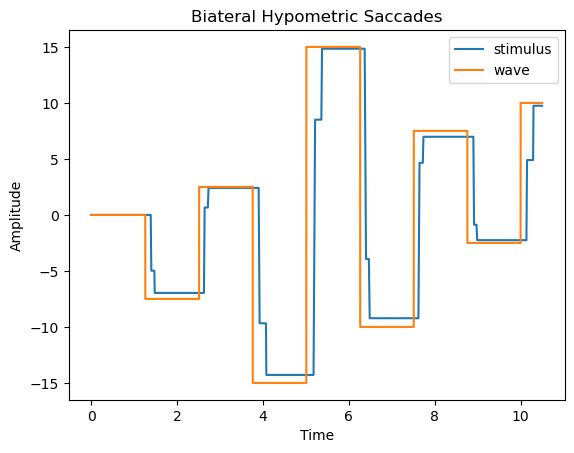

In [443]:
#hypometria
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"A","hypo",3)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Biateral Hypometric Saccades")

Text(0.5, 1.0, 'Biateral Hypermetric Saccades')

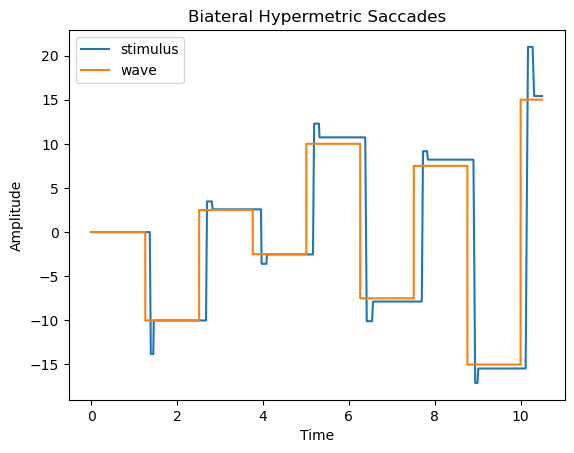

In [445]:
#hypermetria
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"A","hyper",1)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Biateral Hypermetric Saccades")

## Waveforms for unilateral contra and ipsi

could add the if condition to the above gen waveform function but -

In [449]:
def gen_unilateral(stimulus, subject, condition, num):
  wave = [0, 0]
  time = [0, 1.259]
  main_seq = []
  for idx in range(len(stimulus)-1):  # Avoids out-of-range issues with stimulus[idx+1]
    if num == 1: #generating hypers first and then hypos
        if idx % 2 ==0:
          # First time point: Start of the saccade (stim start + latency)
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])
          # print("Step 1:", time[-4:], wave[-4:])

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hyper", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])
          # print("Step 2:", amp, vel, time[-4:], wave[-4:])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude
          # print("Step 3:", lat2, time[-4:], wave[-4:])

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hyper", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])
          # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

        else: #generating hypos first and then hypers
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])   # Appends current stimulus level

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hypo", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hypo", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

    else:
        if idx % 2 ==1:
          # First time point: Start of the saccade (stim start + latency)
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])
          # print("Step 1:", time[-4:], wave[-4:])

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hyper", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])
          # print("Step 2:", amp, vel, time[-4:], wave[-4:])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude
          # print("Step 3:", lat2, time[-4:], wave[-4:])

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hyper", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])
          # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

        else:
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])   # Appends current stimulus level

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hypo", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time2 = time[-1] + np.abs(amp / vel)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hypo", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude



  time.append(10.5)
  wave.append(wave[-1])
  return time, wave, main_seq

Text(0.5, 1.0, 'Unilateral Lesion')

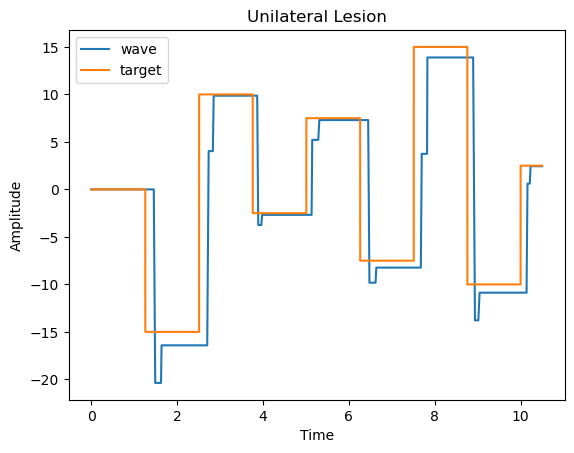

In [451]:
# unilateral
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",1)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["wave","target"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Unilateral Lesion")

In [453]:
stimulus = gen_target(left,right,1)
stimulus

[0, -10, 2.5, -15, 10, -7.5, 7.5, -2.5, 15, 15]

### Pandas dataframe

In [456]:
def make_df(time, waveform, i):
    timesteps = np.arange(0,10500,1)
    wave_1000 = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
    wave_df = pd.DataFrame({"timesteps": (np.array(time) * 1000).astype(int), f"amplitude_{i}": waveform})
    wave_df.set_index("timesteps", inplace=True)
    wave_1000 = wave_1000.join(wave_df, rsuffix=f"_{i}").interpolate(method='linear', limit_direction='both')
    # left_key_counts = wave_1000.index.value_counts()
    # right_key_counts = wave_df.index.value_counts()
    # print("Left key distribution:\n", left_key_counts)
    # print("Right key distribution:\n", right_key_counts)
    # if len(wave_1000) > 10500:
        # print(time);
        # wave_1000 = wave_1000.iloc[:-1,:]
    wave_1000 = wave_1000.join(wave_df,on = "timesteps", rsuffix=f"_{i}")
    # duplicateRows = wave_1000[wave_1000.index.duplicated()]
    # print(duplicateRows)
    return wave_1000

In [458]:
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",1)
unilateral_df = make_df(time,wave,0)
unilateral_df = unilateral_df.iloc[:,:-1]
unilateral_df.rename(columns = {'amplitude_0':'amplitude'},inplace = True)
unilateral_df

,amplitude
timesteps,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
10495,7.485812
10496,7.485812
10497,7.485812


### Making 5 normal, 5 hyper, 5 hypo and adding them to a pandas df

In [461]:
timesteps = np.arange(0,10500,1)

In [463]:
stimulus = gen_target(left,right,1)
# target sequence
reconstructed_laser = gen_reconstructed_laser(stimulus)
stimulus_df = make_df(reconstructed_time,reconstructed_laser,0)
stimulus_1000 = pd.DataFrame(index=timesteps)
stimulus_1000 = stimulus_1000.reset_index()
stimulus_1000.rename(columns = {'index':'timesteps'},inplace = True)
stimulus_1000 = stimulus_1000.join(stimulus_df,on = "timesteps").interpolate(method='linear', limit_direction='both')
stimulus_1000.rename(columns = {'amplitude_0':'amplitude'},inplace = True)
stimulus_1000.shape

(10500, 3)

In [465]:
stimulus_1000

,timesteps,amplitude,amplitude_0_0
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
10495,10495,10.0,10.0
10496,10496,10.0,10.0
10497,10497,10.0,10.0
10498,10498,10.0,10.0


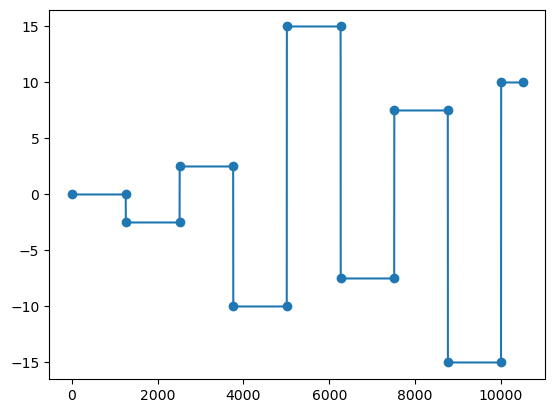

In [467]:
#checking if the 1000Hz stimulus looks good

plt.plot(stimulus_1000.index,stimulus_1000.amplitude)
t = [x*1000 for x in reconstructed_time]
plt.scatter(t,reconstructed_laser)

### 200 Normals, 200 Bilateral Hypos, 200 Bilateral Hypers, 200 Unilateral Lesion (Hypo on Right), 200 Unilateral Lesion (Hypo on Left)

In [470]:
# Create a tuple of tuples

# normal class
x_input_normal_1 = tuple(("N", "none",1) for _ in range(100))
x_input_normal_2 = tuple(("N", "none",2) for _ in range(100))

# bilateral hypometric class
x_input_hypo_1 = tuple(("A", "hypo",1) for _ in range(100))
x_input_hypo_2 = tuple(("A", "hypo",2) for _ in range(100))

# bilateral hypermetric class
x_input_hyper_1 = tuple(("A", "hyper",1) for _ in range(100))
x_input_hyper_2 = tuple(("A", "hyper",2) for _ in range(100))

x_input_list_one = np.concatenate((x_input_normal_1,x_input_normal_2,x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2))

In [472]:
# hypos on right & hypers on left
x_input_uni_1_1 = tuple(("A", "unilateral",1,1) for _ in range(100))
x_input_uni_2_2 = tuple(("A", "unilateral",2,2) for _ in range(100))

# hypers on right & hypos on left
x_input_uni_1_2 = tuple(("A", "unilateral",1,2) for _ in range(100))
x_input_uni_2_1 = tuple(("A", "unilateral",2,1) for _ in range(100))

In [474]:
#0 -> normal, 1-> bilateral hypo, 2 -> bilateral hyper, 3 -> hypo right & hyper left, 4 -> hyper right & hypo left
y_list = np.concatenate(([0]*200, [1]*200, [2]*200,[3]*200, [4]*200))

In [476]:
wave_merged = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
merged_wave = []
stim_df = pd.DataFrame(data=stim_time, columns=["timesteps"])
tensor_combined = torch.empty(0)
stim_combined = torch.empty(0)
mainseq_combined = torch.empty(0)
data = []

for i, row in enumerate(x_input_list_one):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values[:-1])
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_1_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_1_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..


In [477]:
transformed = np.array(data)
num_waves = np.shape(np.array(data))[0]
new = transformed.reshape(num_waves,10500)
wave_1000 = pd.DataFrame(new).T
wave_1000

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,-10.0,-7.5,-15.0,-2.5,-2.5,-15.0,-15.0,-2.5,-2.5,-2.5,...,-2.29894,-6.981978,-7.447356,-9.458717,-2.293559,-14.879876,-14.195266,-7.484801,-13.630375,-14.824276
10496,-10.0,-7.5,-15.0,-2.5,-2.5,-15.0,-15.0,-2.5,-2.5,-2.5,...,-2.29894,-6.981978,-7.447356,-9.458717,-2.293559,-14.879876,-14.195266,-7.484801,-13.630375,-14.824276
10497,-10.0,-7.5,-15.0,-2.5,-2.5,-15.0,-15.0,-2.5,-2.5,-2.5,...,-2.29894,-6.981978,-7.447356,-9.458717,-2.293559,-14.879876,-14.195266,-7.484801,-13.630375,-14.824276
10498,-10.0,-7.5,-15.0,-2.5,-2.5,-15.0,-15.0,-2.5,-2.5,-2.5,...,-2.29894,-6.981978,-7.447356,-9.458717,-2.293559,-14.879876,-14.195266,-7.484801,-13.630375,-14.824276


In [478]:
wave_500 = wave_1000[wave_1000.index % 2 != 0]  # Excludes every 2nd row starting from 0
wave_250 = wave_500[::3]  # Excludes every 2nd row starting from 0
wave_125 = wave_250[::2]  # Excludes every 2nd row starting from 0

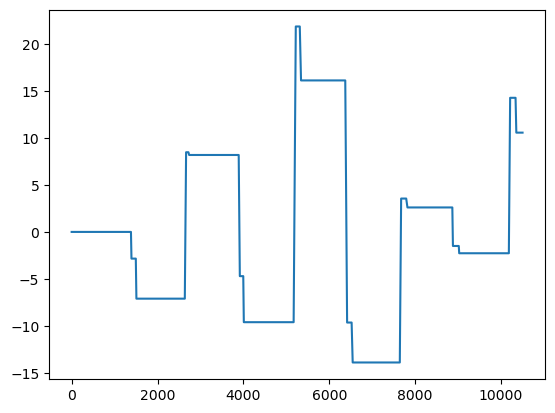

In [484]:
plt.plot(wave_1000.index,wave_1000.iloc[:,801])

### Comparing the 1000 Hz waveform to downsampled version

In [487]:
plt.plot(timesteps, wave_1000[:,1])
plt.plot(wave_500.index, wave_500[:,1], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","500Hz"])
plt.xlim(1350,1600)

KeyError: (slice(None, None, None), 1)

In [321]:
plt.plot(timesteps, wave_1000.amplitude_3)
plt.plot(wave_250.index, wave_250.amplitude_3, c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","250Hz"])
plt.xlim(1350,1600)

AttributeError: 'DataFrame' object has no attribute 'amplitude_3'

(1350.0, 1600.0)

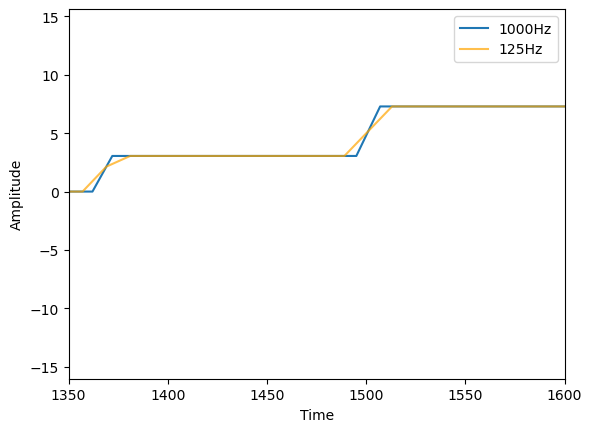

In [220]:
plt.plot(timesteps, wave_1000.amplitude_3)
plt.plot(wave_125.index, wave_125.amplitude_3, c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","125Hz"])
plt.xlim(1350,1600)

In [222]:
# wave_merged.to_csv("output.csv", index=False)

### Train test split

In [233]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    wave_interpolate, y_list, test_size=0.3, random_state=42)

NameError: name 'wave_interpolate' is not defined

In [235]:
print(f"wave_interpolate shape: {wave_interpolate.shape}")
print(f"y_list shape: {y_list.shape}")


NameError: name 'wave_interpolate' is not defined

## Checking if the velocity amplitue duration follow the main sequence


In [238]:
main_seq_data = pd.read_csv(r"/content/main_seq.csv")
# main_seq_data.drop(main_seq_data,inplace=True)
main_seq_data
# main_seq_data.columns = ["vel","amp","dur"]
# main_seq_data.amplitude = main_seq_data.amplitude.applymap(lambda x: np.abs(x))
# df = df.applymap(lambda x: x + 1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/main_seq.csv'

In [240]:
plt.scatter(main_seq_data.amp,main_seq_data.dur)
plt.xlabel("Amplitude")
plt.ylabel("Duration")

NameError: name 'main_seq_data' is not defined

In [242]:
from sklearn import datasets, linear_model
x =  main_seq_data.amp.values.reshape(36000,1)
y =main_seq_data.dur.values.reshape(36000,1)
regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

NameError: name 'main_seq_data' is not defined

In [ ]:
regr.coef_*1000

In [245]:
regr.intercept_*1000

NameError: name 'regr' is not defined

## Showing oth fitted curve and data for the velocity generation

In [249]:
xy_1 = pd.read_csv("/content/xy_data_amp_less_than_6.txt", sep="\t", header = None, names=["amp","vel"])
xy_2 = pd.read_csv("/content/xy_data_curve_fitting.txt", sep="\t", header = None, names=["amp","vel"])


FileNotFoundError: [Errno 2] No such file or directory: '/content/xy_data_amp_less_than_6.txt'

In [ ]:
popt_fs, pcov_fs = curve_fit(func_fixsqrt, xy_2.amp, xy_2.vel)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

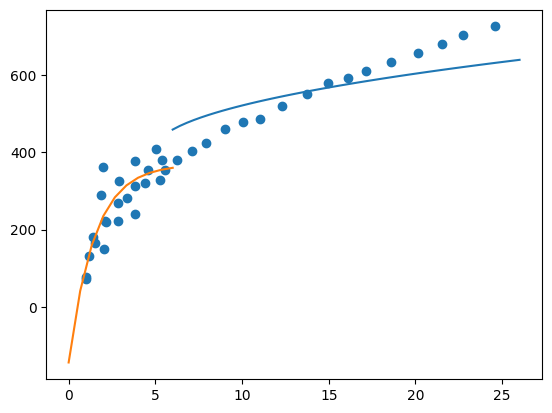

In [ ]:
xy = pd.concat([xy_1,xy_2])
plt.scatter(xy.amp,xy.vel)
ran_x = np.linspace(6,26,50)
y = func_fixsqrt(ran_x, *popt_fs)
ran_x2 = np.linspace(0,6,10)
y2 = func_exp(ran_x2,*popt_exp)
plt.plot(ran_x,y)
plt.plot(ran_x2,y2)

## ttt

In [489]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [491]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1000 Hz Model Run

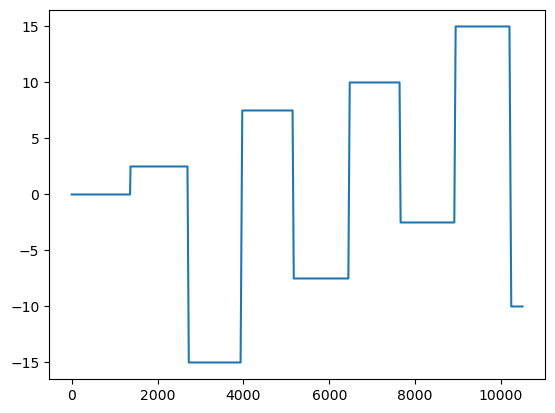

In [494]:
# Normal Saccade
plt.plot(wave_1000.index,wave_1000.iloc[:,0])

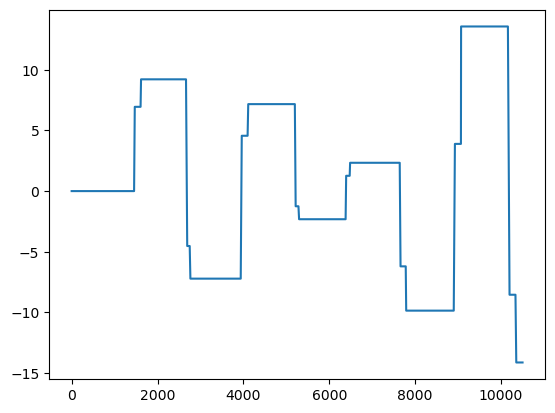

In [496]:
# Bilateral Hypometric
plt.plot(wave_1000.index,wave_1000.iloc[:,201])

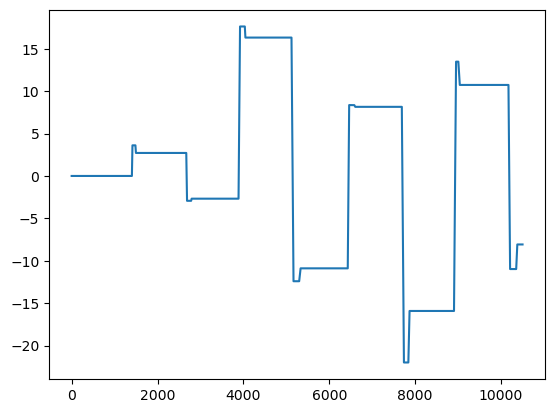

In [498]:
# Bilateral Hypermetric
plt.plot(wave_1000.index,wave_1000.iloc[:,401])

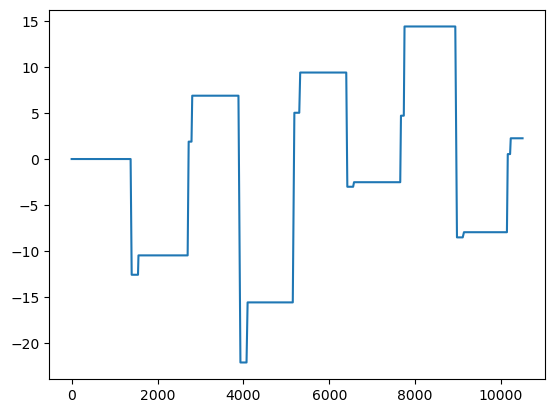

In [500]:
# Hyper left & hypo right
plt.plot(wave_1000.index,wave_1000.iloc[:,601])

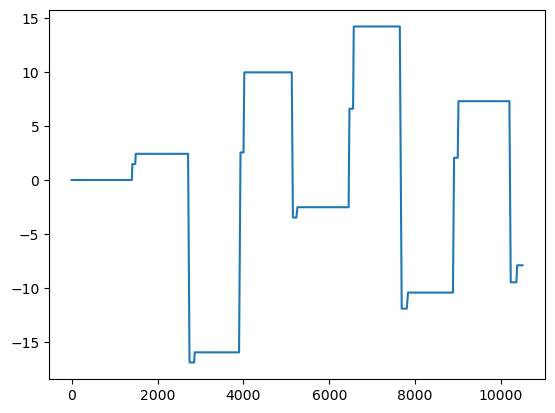

In [502]:
# Hyper left & hypo right
plt.plot(wave_1000.index,wave_1000.iloc[:,701])

In [504]:
X = wave_1000.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(1000, 10500, 1)

In [506]:
# Labels: 0 - normal, 1 - hypometria, 2 - hypermetria
y = to_categorical(y_list)  # Convert to one-hot encoding
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [508]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (800, 10500, 1), y_train shape: (800, 5)
X_test shape: (200, 10500, 1), y_test shape: (200, 5)


In [510]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.2661 - loss: 20.7257 - val_accuracy: 0.3000 - val_loss: 1.5114
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.2920 - loss: 1.4719 - val_accuracy: 0.3812 - val_loss: 1.3289
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.3339 - loss: 1.4008 - val_accuracy: 0.5312 - val_loss: 1.2307
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.4479 - loss: 1.2641 - val_accuracy: 0.5938 - val_loss: 1.1154
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.5089 - loss: 1.1051 - val_accuracy: 0.6438 - val_loss: 0.9281
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5184 - loss: 1.0486 - val_accuracy: 0.5875 - val_loss: 0.8967
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.5087 - loss: 1.0557 - val_accuracy: 0.7625 - val_loss: 0.7322
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.5385 - loss: 0.9122 - val_accuracy: 0.7563 - val

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


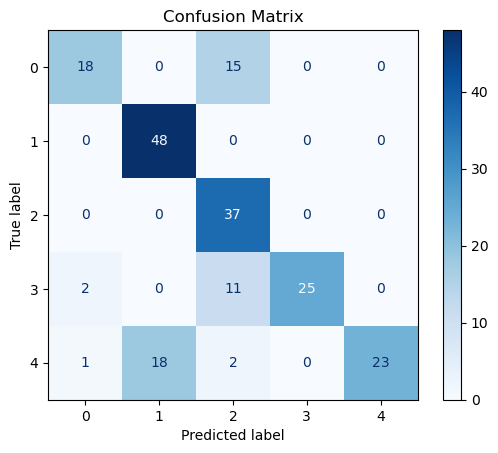

In [342]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()